# TensorFlow Variational Inference

## Mike's example

In [73]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

In [74]:
# Distribution we are trying to emulate
K1 = tfd.MultivariateNormalTriL(loc=[1.0, 2.0], scale_tril=tf.linalg.cholesky([[2.0, 0.5], [0.5, 1.0]]))
K2 = tfd.MultivariateNormalTriL(loc=[3.0, 4.0], scale_tril=tf.linalg.cholesky([[1.0, 0.0], [0.0, 0.5]]))

# Value of the pdf at x
def pdist(x):
    return 2*K1.prob(x)+K2.prob(x)

# log of the pdf
def logpdist(x):
    logp = tf.math.log(1e-30+pdist(x))
    assert(np.all(np.isfinite(logp)))
    return logp

In [75]:
# KL divergence is the loss/discrepency function
discrepancy_fn = tfp.vi.kl_reverse
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
# mu initialised as 0
mu = tf.Variable([0.0,0.0],dtype=tf.float32)
# covariance initialised
scale = tf.Variable([[20.0,0],[0,20.0]],dtype=tf.float32)

In [76]:
# Want to learn mean and covariance of the MVN
for it in range(1000):
    with tf.GradientTape() as tape:
        surrogate_posterior = tfd.MultivariateNormalTriL(mu,scale_tril=scale)
        elbo_loss = tfp.vi.monte_carlo_variational_loss(logpdist,surrogate_posterior,sample_size=1000,discrepancy_fn=discrepancy_fn) #,use_reparametrization=True)
        gradients = tape.gradient(elbo_loss, [mu,scale])
        optimizer.apply_gradients(zip(gradients, [mu,scale]))
        if it%50==0: 
            print("%0.3f, %0.3f, %0.3f" % (scale.numpy()[0,0],mu.numpy()[0],elbo_loss.numpy()))

19.900, -0.100, 54.230
14.405, 0.891, 48.827
6.781, 1.196, 24.258
1.281, 1.777, -0.881
1.558, 1.643, -1.020
1.548, 1.580, -1.057
1.544, 1.641, -1.054
1.558, 1.644, -1.058
1.547, 1.630, -1.058
1.543, 1.613, -1.061
1.541, 1.648, -1.037
1.548, 1.559, -1.072
1.557, 1.639, -1.026
1.573, 1.588, -1.053
1.552, 1.642, -1.045
1.547, 1.652, -1.038
1.558, 1.643, -1.072
1.524, 1.590, -1.052
1.531, 1.637, -1.048
1.540, 1.593, -1.052


## SparseGP Attempt

In [77]:
import gpflow

Learn a sparse approximation for the following function:
$$f(x) = \cos(2x) + \sqrt{x} - \sin(5x)$$

(50, 100)


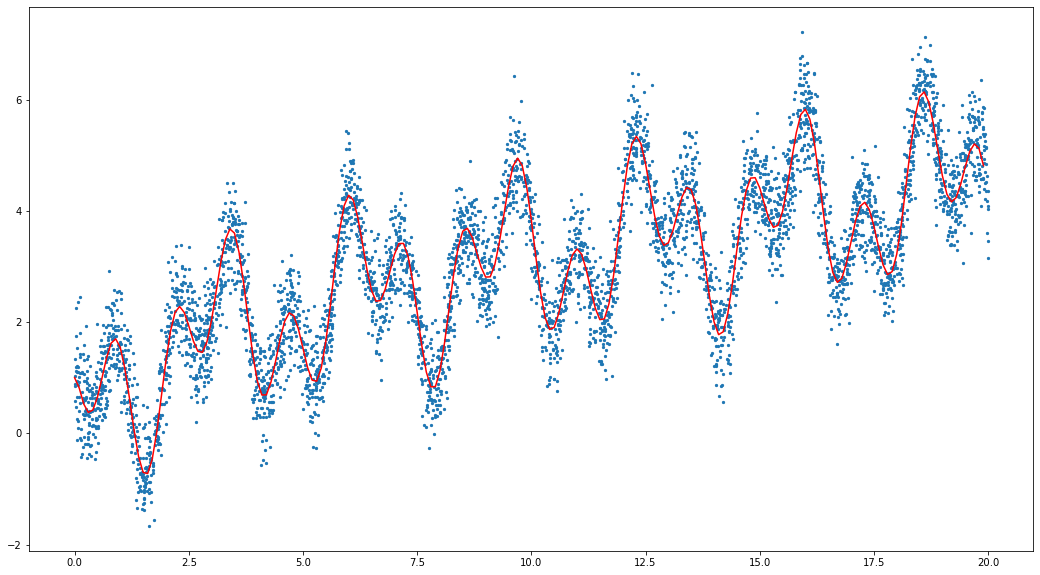

In [78]:
# Generate data
# Constants
GAUSSIANNOISE = 0.5
XRANGE = (0, 20)
N = 5000


def f(x):
    return np.cos(2*x) + np.sqrt(x) - np.sin(5*x)

# Generate X and y
X = np.random.uniform(low=XRANGE[0], high=XRANGE[1], size=(N, 1))
y = f(X) + np.random.normal(0, GAUSSIANNOISE, size=(N, 1))

# Get indices for random batches of 100 points
batch_indices = np.arange(0, N)
np.random.shuffle(batch_indices)
batch_indices = batch_indices.reshape(-1, 100)

print(batch_indices.shape)

plt.figure(figsize=(18, 10))
plt.scatter(X, y, s=5)
Xt = np.arange(*XRANGE, 0.1)
Yt = f(Xt)
plt.plot(Xt, Yt, c='red')
plt.show()

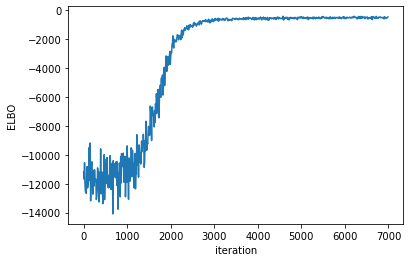

In [118]:
k = gpflow.kernels.Matern52()
Z = X[::100]
sparse_gp = gpflow.models.SVGP(kernel = k, likelihood = gpflow.likelihoods.Gaussian(), inducing_variable = Z)
elbo = tf.function(sparse_gp.elbo)

minibatch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices((X, y)).repeat().shuffle(N)
train_iter = iter(train_dataset.batch(minibatch_size))

minibatch_size = 100

# We turn off training for inducing point locations
gpflow.set_trainable(sparse_gp.inducing_variable, True)


def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()
    
    model.likelihood.variance.assign(0.05)
    model.kernel.lengthscales.assign(0.01)
    model.kernel.variance.assign(0.2)
    gpflow.set_trainable(model.likelihood.variance, False)
    

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        if step > iterations*0.8:
            gpflow.set_trainable(model.likelihood.variance, True)
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

maxiter = 7000

logf = run_adam(sparse_gp, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

In [119]:
sparse_gp

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.258572358464088
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.535390275104566
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.05000000000000001
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(50, 1)",float64,[[19.0795875...
SVGP.q_mu,Parameter,Identity,,True,"(50, 1)",float64,[[3.82314102...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 50, 50)",float64,"[[[1.48700666e-01, 0.00000000e+00, 0.00000000e+00..."


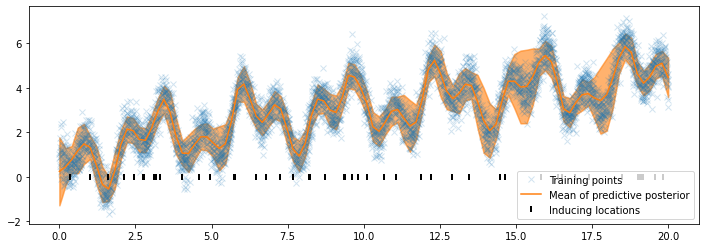

In [120]:
def plot(m, title=""):
    plt.figure(figsize=(12, 4))
    plt.title(title)
    pX = np.linspace(0, 20, 100)[:, None]  # Test locations
    pY, pYv = m.predict_y(pX)  # Predict Y values at test locations
    plt.plot(X, y, "x", label="Training points", alpha=0.2)
    (line,) = plt.plot(pX, pY, lw=1.5, label="Mean of predictive posterior")
    col = line.get_color()
    plt.fill_between(
        pX[:, 0],
        (pY - 2 * pYv ** 0.5)[:, 0],
        (pY + 2 * pYv ** 0.5)[:, 0],
        color=col,
        alpha=0.6,
        lw=1.5,
    )
    Z = m.inducing_variable.Z.numpy()
    plt.plot(Z, np.zeros_like(Z), "k|", mew=2, label="Inducing locations")
    plt.legend(loc="lower right")
    
plot(sparse_gp)

In [ ]:
# Learn SparseGP
k = gpflow.kernels.Matern52()

# KL divergence is the loss/discrepency function
discrepancy_fn = tfp.vi.kl_reverse
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
# mu initialised as 0
mu = tf.Variable(tf.zeros(2),dtype=tf.float32)
# covariance initialised
scale = tf.Variable(tf.eye(2),dtype=tf.float32)

# Inducing points
Z = X[::100]

batches = [batch_indices[i, :] for i in range(batch_indices.shape[0])]

for i, batch in enumerate(batches):
    with tf.GradientTape() as tape:
        batch_X = X[batch, :]
        batch_y = y[batch, :]
        gp = gpflow.models.GPR(data = (batch_X, batch_y), kernel = k)
        surrogate_posterior = tfd.MultivariateNormalTriL(mu, scale_tril = scale)
        elbo_loss = tfp.vi.monte_carlo_variational_loss(gp.predict_log_density, surrogate_posterior, sample_size=1000, discrepancy_fn=discrepancy_fn) #,use_reparametrization=True)
        gradients = tape.gradient(elbo_loss, [mu,scale])
        optimizer.apply_gradients(zip(gradients, [mu,scale]))
        if batch_ind%50==0: 
            print("%0.3f, %0.3f, %0.3f" % (scale.numpy()[0,0],mu.numpy()[0],elbo_loss.numpy()))

## Questions
* Is `pdist` our 'true' probability distribution, i.e p?
* Is `surrogate_posterior` the distribution we're trying to fit to the true dist, i.e q?